In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

2022-09-17 15:06:52.104417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 15:06:52.114225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 15:06:52.115289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 15:06:52.117103: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)


#### Use Conv1D for single dimension. Append a pooling layer to reduce the output of the convolution layer.
Can try GlobalMaxPooling1D or average pooling

In [3]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 20
filters = 128
kernel_size = 5

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'filters: {filters}')
print(f'kernel_size: {kernel_size}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)


2022-09-17 15:08:57.961405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-09-17 15:08:59.741738: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


In [4]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
filters = 128
kernel_size = 5
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
__________________________________________________

In [5]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10


2022-09-17 15:09:35.301493: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


98/98 [==============================] - 11s 102ms/step - loss: 0.6158 - accuracy: 0.6659 - val_loss: 0.4201 - val_accuracy: 0.8120
Epoch 2/10
98/98 [==============================] - 4s 45ms/step - loss: 0.3046 - accuracy: 0.8722 - val_loss: 0.2787 - val_accuracy: 0.8843
Epoch 3/10
98/98 [==============================] - 4s 37ms/step - loss: 0.1605 - accuracy: 0.9431 - val_loss: 0.2757 - val_accuracy: 0.8886
Epoch 4/10
98/98 [==============================] - 3s 34ms/step - loss: 0.0711 - accuracy: 0.9824 - val_loss: 0.3049 - val_accuracy: 0.8890
Epoch 5/10
98/98 [==============================] - 3s 34ms/step - loss: 0.0248 - accuracy: 0.9972 - val_loss: 0.3320 - val_accuracy: 0.8897
Epoch 6/10
98/98 [==============================] - 3s 34ms/step - loss: 0.0084 - accuracy: 0.9997 - val_loss: 0.3654 - val_accuracy: 0.8900
Epoch 7/10
98/98 [==============================] - 3s 33ms/step - loss: 0.0040 - accuracy: 0.9999 - val_loss: 0.3908 - val_accuracy: 0.8898
Epoch 8/10
98/98 [====

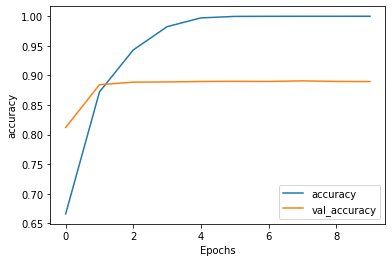

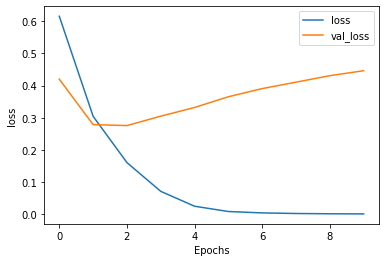

In [7]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")